If you're running this notebook locally on your own machine, you can ignore the following cell. If you want to [run this notebook remotely on Google's Colab platform](https://colab.research.google.com/github/tsafavi/codex/blob/master/Explore%20CoDEx.ipynb), uncomment and run the lines in the following cell: 

In [1]:
# !git clone https://github.com/tsafavi/codex
# %cd codex
# !./extract.sh en  # unzip all KG text in English
# !pip install -r requirements.txt
# !pip install -e .

If you're running on Colab, you will need to restart the runtime after running the previous cell.

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from codex.codex import Codex

In [3]:
sizes = Codex.SIZES
codes = Codex.CODES

# Data exploration
Load our data and do basic exploratory analysis.

In [4]:
for size in sizes:
    codex = Codex(size=size)
    
    train, valid, test = [
        codex.split(split) for split in ("train", "valid", "test")]
    triples = codex.triples()
    
    print(codex.name())
    
    print(
        " ", len(codex.entities()), "entities /",
        len(codex.relations()), "relations"
    )
        
    print(
        " ", len(train), "train /",
        len(valid), "validation /",
        len(test), "test"
    )
    print(" ", len(triples), "total triples")

CoDEx-S
  2034 entities / 42 relations
  32888 train / 1827 validation / 1828 test
  36543 total triples
CoDEx-M
  17050 entities / 51 relations
  185584 train / 10310 validation / 10311 test
  206205 total triples
CoDEx-L
  77951 entities / 69 relations
  551193 train / 30622 validation / 30622 test
  612437 total triples


Inspect a single entity.

In [5]:
eid = "Q51"

for code in codes:
    codex = Codex(code=code)
    print(codex.entity_label(eid))

القارة القطبية الجنوبية
Antarktika
Antarctica
Antártida
Антарктида
南极洲


In [6]:
codex = Codex(code="en")
print(f"From {codex.entity_wikipedia_url(eid)}:")
print(f"  '{codex.entity_extract(eid)}'")

From https://en.wikipedia.org/wiki/Antarctica:
  'Antarctica ( or  (listen)) is Earth's southernmost continent. It contains the geographic South Pole and is situated in the Antarctic region of the Southern Hemisphere, almost entirely south of the Antarctic Circle, and is surrounded by the Southern Ocean. At 14,200,000 square kilometres (5,500,000 square miles), it is the fifth-largest continent and nearly twice the size of Australia. At 0.00008 people per square kilometre, it is by far the least densely populated continent. About 98% of Antarctica is covered by ice that averages 1.9 km (1.2 mi; 6,200 ft) in thickness, which extends to all but the northernmost reaches of the Antarctic Peninsula.
Antarctica, on average, is the coldest, driest, and windiest continent, and has the highest average elevation of all the continents. Most of Antarctica is a polar desert, with annual precipitation of 200 mm (7.9 in) along the coast and far less inland; there has been no rain there for almost 2 m

Explore entity types.

In [7]:
codex = Codex(code="en")
types = codex.entity_types(eid)
for etype in types:
    print(codex.entity_label(eid), "is of type", codex.entity_type_label(etype))

Antarctica is of type continent
Antarctica is of type geographic region


In [8]:
type_id = "Q5"
print(f"From {codex.entity_type_wikipedia_url(type_id)}:")
print(f"  '{codex.entity_type_extract(type_id)}'")

From https://en.wikipedia.org/wiki/Human:
  ''


Inspect a single relation.

In [9]:
rid = "P530"
print(codex.relation_label(rid) + ":", codex.relation_description(rid))

diplomatic relation: diplomatic relations of the country


Explore some of the negative triples.

In [10]:
for size in ("s", "m"):
    codex = Codex(size=size)
    valid_neg, test_neg = (
        codex.negative_split("valid"),
        codex.negative_split("test")
    )
    print(
        codex.name(), "has", 
        len(valid_neg), "validation negatives and",
        len(test_neg), "test negatives"
    )
    
    print("Samples:")
    sample = test_neg.sample(n=5)

    rows = [(tuple(row)) for row in sample.values]
    for h, r, t in rows:
        print(" ",
              f"({codex.entity_label(h)},",
              f"{codex.relation_label(r)},", 
              f"{codex.entity_label(t)})")

CoDEx-S has 1827 validation negatives and 1828 test negatives
Samples:
  (Lion Feuchtwanger, country of citizenship, Italy)
  (Josephine Baker, country of citizenship, Israel)
  (Avril Lavigne, country of citizenship, India)
  (Thomas Paine, country of citizenship, Hungary)
  (Bud Spencer, country of citizenship, Brazil)
CoDEx-M has 10310 validation negatives and 10311 test negatives
Samples:
  (Keith Murray, record label, Capitol Records)
  (A Nightmare on Elm Street, cast member, Roger Corman)
  (Arthur Miller, occupation, diarist)
  (Rob Reiner, country of citizenship, Canada)
  (Johann Amos Comenius, ethnic group, French people)


Make sure none of the negative triples are actually positives.

In [11]:
all_triples = {tuple(row) for row in pd.concat(
    [Codex(size=size).triples() for size in sizes]).values}
    
for size in ("s", "m"):
    codex = Codex(size=size)
    valid_neg, test_neg = (
        codex.negative_split("valid"),
        codex.negative_split("test")
    )
    
    for neg_triples in (valid_neg, test_neg):
        neg_triples = {tuple(row) for row in neg_triples.values}
        assert not len(neg_triples.intersection(all_triples))
        
print("Passed all checks successfully")

Passed all checks successfully


# Plotting
Plot various properties like degree distribution and top-k entities/relations.

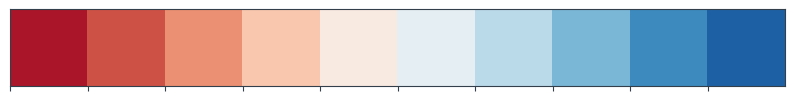

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.getLogger("matplotlib.font_manager").disabled = True

# Styles from https://scentellegher.github.io/visualization/2018/10/10/beautiful-bar-plots-matplotlib.html

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Helvetica"

plt.rcParams["axes.linewidth"] = 0.8
plt.rcParams["legend.frameon"] = False

dark_grey = "#333F4B"
plt.rcParams["text.color"] = dark_grey
keys = [
    "axes.edgecolor",
    "axes.labelcolor",
    "xtick.color",
    "ytick.color"
]
for key in keys:
    plt.rcParams[key] = dark_grey

palette = sns.color_palette("RdBu", 10)
# sns.palplot(palette)

Plot the degree distribution of CoDEx datasets.

In [12]:
def count_entities(triples):
    """Get the degree of all entities across train/valid/test"""
    entities = pd.concat((triples["head"], triples["tail"]))
    df = pd.DataFrame(
        entities.value_counts().reset_index(),
    )
    df.columns = ["entity", "count"]
    return df

def count_relations(triples):
    """Get relation mention counts"""
    df = pd.DataFrame(
        triples["relation"].value_counts().reset_index(),
    )
    df.columns = ["relation", "count"]
    return df

In [13]:
def plot_degree_distribution(
        triples, step=5, ax=None, 
        figsize=(5,3), **kwargs):
    """Plot the degree distribution of all entities
    in a set of triples"""
    counts = count_entities(triples)["count"]
    print(f"Average degree: {counts.mean():.2f}")
    
    x = np.arange(0, max(counts), step)
    y = [len(counts[counts > val]) for val in x]
    y = np.array(y, dtype=np.float32)

    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    
    ax.scatter(x, y, alpha=0.5, **kwargs)
    ax.set_xscale("symlog")
    ax.set_yscale("symlog")
    
    ax.set_xlabel("Entity degree", fontsize=14)
    ax.set_ylabel("Cumulative count", fontsize=12)
    
    ax.tick_params(
        which="both",
        labelsize=12
    )
    
    ax.spines["top"].set_color("none")
    ax.spines["right"].set_color("none")
    ax.spines["left"].set_smart_bounds(True)
    ax.spines["bottom"].set_smart_bounds(True)

    return ax

Average degree: 35.93


AttributeError: 'Spine' object has no attribute 'set_smart_bounds'

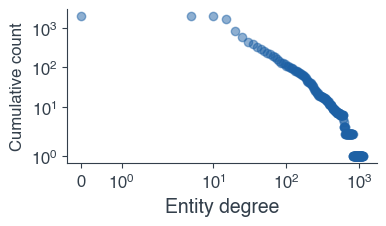

In [14]:
for size in sizes:
    codex = Codex(size=size)
    triples = codex.triples()

    ax = plot_degree_distribution(
        triples, 
        color=palette[-1],
        step=5,
        figsize=(4, 2),
        label=codex.name(),
    )

    legend = ax.legend(
        frameon=False, 
        fontsize=14,
        handletextpad=0.001,
        labelspacing=0.2,
        loc=3
    )

    for text in legend.get_texts():
        text.set_color(dark_grey)

    for lh in legend.legendHandles: 
        lh.set_alpha(0.7)

    xlim = ax.get_xlim()
    ax.set_xlim(3, max(xlim))

    plt.show()

Plot the top-k entities and relations in a CoDEx dataset.

In [15]:
def plot_top_k(count_df, k=30, 
               label_col="label",
               count_col="count",
               figsize=(5,8.5),
               color="#007acc",
               ax=None,
               **kwargs):
    count_df = count_df.sort_values(count_col, ascending=False).head(k)
    top_labels, top_counts = count_df[label_col], count_df[count_col]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    x = np.arange(k)
    y = top_counts[::-1]
        
    ax.hlines(
        y=x,
        xmin=0, 
        xmax=y, 
        color=color, 
        alpha=0.2, 
        linewidth=5,
        **kwargs
    )
    
    ax.plot(
        y, x, "o", 
        markersize=7, 
        color=color, 
        alpha=0.6)
    
    ax.spines["top"].set_color("none")
    ax.spines["right"].set_color("none")

    ax.spines["left"].set_bounds(0, k - 1)
    ax.spines["bottom"].set_bounds(0, max(ax.get_xticks()))
    
    ax.set_xlabel("Count", fontsize=14)

    ax.set_yticks(x)
    ax.set_yticklabels(top_labels[::-1])
    
    return ax

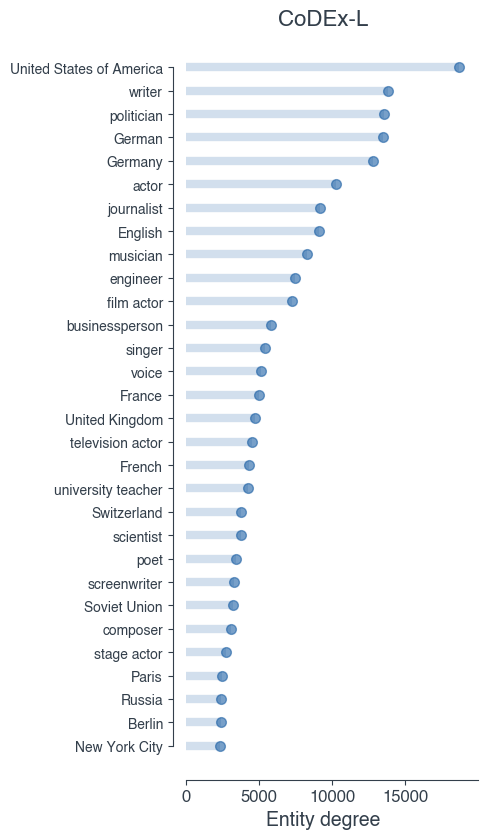

In [16]:
size = "l"
codex = Codex(size=size)

triples = codex.triples()
count_df = count_entities(triples)

count_df["label"] = [
    codex.entity_label(eid) for eid in count_df["entity"]]

k = 30

ax = plot_top_k(
    count_df, 
    k=k, 
    color=palette[-1],
    linewidths=6
)

ax.set_xscale("linear")
ax.set_xlabel("Entity degree", fontsize=14)
ax.set_title(codex.name(), fontsize=16)
ax.tick_params("x", labelsize=12)

plt.tight_layout()
plt.show()

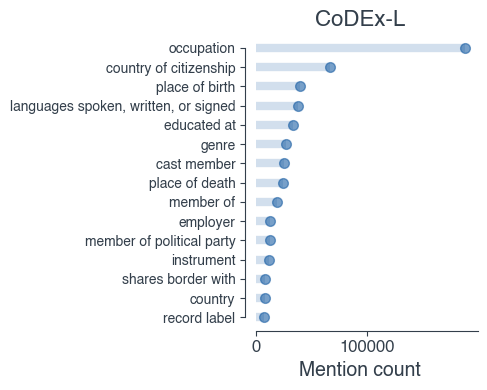

In [17]:
count_df = count_relations(triples)
count_df["label"] = [
    codex.relation_label(rid) for rid in count_df["relation"]]

k = 15

ax = plot_top_k(
    count_df, 
    k=k, 
    color=palette[-1],
    linewidths=6,
    figsize=(5, 4)
)

ax.set_xscale("linear")
ax.set_xlabel("Mention count", fontsize=14)
ax.set_title(codex.name(), fontsize=16)
ax.tick_params("x", labelsize=12)

plt.tight_layout()
plt.show()

Investigate symmetry.

In [18]:
def entity_pairs(triples, reverse=False):
    """Get all unique head/tail entity pairs in a set of triples"""
    col1, col2 = "head", "tail"
    if reverse:
        col1, col2 = col2, col1
    return set(zip(triples[col1], triples[col2]))

In [19]:
threshold = 0.5

for size in sizes: 
    codex = Codex(size=size)
    print("----------" + codex.name() + "----------")
    relations = codex.relations()
    triples = codex.triples()
    tot = 0
    
    for relation in relations:
        triples_r = triples[triples["relation"] == relation]
        
        forward, reverse = entity_pairs(triples_r), \
            entity_pairs(triples_r, reverse=True)
        symmetry = len(forward.intersection(reverse)) / len(forward)
        percent = len(triples_r) / len(triples)
        
        if symmetry > threshold:
            print(
                f"  {codex.relation_label(relation)} ({relation})", 
                f"| {symmetry * 100:.2f}% symmetry", 
                f"| {percent * 100:.3f}% of {codex.name()}"
            )
            
            tot += (percent * 100)
                
    print(f"Symmetric relations > {threshold:.1f} make up {tot:.2f}% of {codex.name()}")

----------CoDEx-S----------
  unmarried partner (P451) | 78.26% symmetry | 0.126% of CoDEx-S
  sibling (P3373) | 100.00% symmetry | 0.268% of CoDEx-S
  diplomatic relation (P530) | 97.08% symmetry | 16.890% of CoDEx-S
  spouse (P26) | 98.46% symmetry | 0.178% of CoDEx-S
Symmetric relations > 0.5 make up 17.46% of CoDEx-S
----------CoDEx-M----------
  unmarried partner (P451) | 83.97% symmetry | 0.191% of CoDEx-M
  sibling (P3373) | 98.09% symmetry | 0.381% of CoDEx-M
  diplomatic relation (P530) | 97.06% symmetry | 3.019% of CoDEx-M
  spouse (P26) | 97.00% symmetry | 0.420% of CoDEx-M
Symmetric relations > 0.5 make up 4.01% of CoDEx-M
----------CoDEx-L----------
  unmarried partner (P451) | 79.70% symmetry | 0.109% of CoDEx-L
  sibling (P3373) | 76.53% symmetry | 0.471% of CoDEx-L
  shares border with (P47) | 90.36% symmetry | 1.321% of CoDEx-L
  diplomatic relation (P530) | 96.80% symmetry | 1.026% of CoDEx-L
  spouse (P26) | 89.23% symmetry | 0.358% of CoDEx-L
Symmetric relations > 0

Investigate compositionality.

In [20]:
import os

In [21]:
def rule_relations(rule):
    return [item for item in rule.split(" ") if item.startswith("P")]

In [22]:
for size in sizes:
    codex = Codex(size=size)
    name = codex.name()
    print("----------" + name + "----------")
    
    rule_df = pd.read_csv(
        os.path.join("analysis/paths", f"codex-{size}", "paths.tsv"), sep="\t"
    )
        
    # Count number of paths in this core
    # Get the average confidence across all rules
    print(
        len(rule_df), "paths in", name
    )
    
    avg_conf = rule_df["PCA Confidence"].mean()
    print(f"Average confidence: {avg_conf:.3f}")
    
    frac_of_total = (
        np.sum(np.multiply(rule_df["Positive Examples"], rule_df["Length"])) / 
        len(codex.triples()) * 100
    )
    print(f"n pos / n triples: {frac_of_total:.2f}%")
        
    # Print a few examples
    print("Examples:")
    for length in (2, 3):
        df = rule_df[rule_df["Length"] == length]
        sample = df.sample(n=1)
        rule, conf = sample["Rule"].iloc[0], sample["PCA Confidence"].iloc[0]
        relations = rule_relations(rule)
        
        print(
            " ",
            "/".join([codex.relation_label(relation) for relation in relations[:-1]]), 
            "->", 
            codex.relation_label(relations[-1]),
            f"(confidence {conf:.3f})"
        )

----------CoDEx-S----------
26 paths in CoDEx-S
Average confidence: 0.630
n pos / n triples: 10.09%
Examples:
  unmarried partner/residence -> place of birth (confidence 0.800)
  country of citizenship/head of state/residence -> place of death (confidence 0.168)
----------CoDEx-M----------
44 paths in CoDEx-M
Average confidence: 0.556
n pos / n triples: 16.55%
Examples:
  founded by/continent -> continent (confidence 0.571)
  cast member/record label/location of formation -> country of origin (confidence 0.114)
----------CoDEx-L----------
93 paths in CoDEx-L
Average confidence: 0.459
n pos / n triples: 31.84%
Examples:
  named after/sibling -> named after (confidence 0.152)
  cast member/spouse/country of citizenship -> country of origin (confidence 0.558)
